# Image Classification with AWS SageMaker
In this notebook we will be leveraging AWS SageMaker to fine-tune a pre-trained model for the task of image classification.
We are implementing SageMaker's profiling and debugging tools to monitor model training and performance and we conduct hyperparameter tuning to optimize our model's performance.
Finally the model is deployed to a SageMaker endpoint and tested.

### OPTIONAL: Pickle tool - Save variables in case of Kernel restart

In [ ]:
#Exclude Non-Pickleable Variables, save others
import pickle
import types

# Function to test if an object can be pickled
def is_pickleable(obj):
    try:
        pickle.dumps(obj)
        return True
    except (pickle.PicklingError, TypeError, AttributeError):
        return False

# Filter pickleable variables
variables_to_save = {
    key: value
    for key, value in globals().items()
    if not key.startswith("__") and not isinstance(value, types.ModuleType) and is_pickleable(value)
}

# Save pickleable variables to a file
with open("all_variables.pkl", "wb") as f:
    pickle.dump(variables_to_save, f)

print(f"Saved {len(variables_to_save)} pickleable variables to all_variables.pkl")

### OPTIONAL: Load variables after Kernel reset

In [ ]:
import pickle

# Load variables from the pickle file
with open("all_variables.pkl", "rb") as f:
    loaded_variables = pickle.load(f)

# Restore variables to the current session
globals().update(loaded_variables)

print("Variables loaded successfully!")

### Check dependencies

In [1]:
import torchvision
print(torchvision.__version__)

0.20.1+cpu


In [2]:
import numpy as np
print(np.__version__)

1.26.4


In [6]:
!python -c "import smdebug; print(smdebug.__version__)"

1.0.34


In [7]:
!which python  # Linux/MacOS

/home/ec2-user/anaconda3/envs/python3/bin/python


In [8]:
!conda info --envs

# conda environments:
#
base                     /home/ec2-user/anaconda3
JupyterSystemEnv         /home/ec2-user/anaconda3/envs/JupyterSystemEnv
R                        /home/ec2-user/anaconda3/envs/R
python3               *  /home/ec2-user/anaconda3/envs/python3
pytorch_p310             /home/ec2-user/anaconda3/envs/pytorch_p310
tensorflow2_p310         /home/ec2-user/anaconda3/envs/tensorflow2_p310



### OPTIONAL: Install requirements

In [ ]:
#!pip check

In [ ]:
#!pip install torch torchvision

In [ ]:
#!pip uninstall torch torchvision -y

In [ ]:
#!pip install torch torchvision --index-url https://download.pytorch.org/whl/cpu

In [ ]:
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [ ]:
#!pip install --upgrade pip setuptools wheel

In [ ]:
#!pip install --upgrade packaging

In [ ]:
#!pip install mkl

In [ ]:
#!pip install sphinx==8.1.3

In [ ]:
#!pip install docutils==0.21

### OPTIONAL: Reinstalling smdebug and dependencies

In [ ]:
#!pip install --upgrade --force-reinstall smdebug

In [ ]:
#!python -c "import smdebug; print(smdebug.__version__)"

In [ ]:
#pip install --upgrade --force-reinstall numpy

In [ ]:
#pip install protobuf==3.20.3

In [ ]:
#pip install --upgrade --force-reinstall scipy pandas

In [ ]:
#pip check

In [ ]:
#pip install awscli==1.36.34 botocore==1.35.93 docutils==0.16 s3transfer==0.10.0

In [ ]:
#pip install boto3==1.36.2 botocore==1.36.2 s3transfer==0.11.0

In [ ]:
#pip install numpy==1.24.3

In [ ]:
#pip install docutils==0.21

In [ ]:
#pip list | grep -E "awscli|botocore|docutils|s3transfer"

In [ ]:
#pip uninstall awscli botocore docutils s3transfer -y

In [ ]:
#pip install awscli==1.36.34 botocore==1.35.93 docutils==0.16 s3transfer==0.10.0

In [ ]:
#pip list | grep -E "awscli|botocore|docutils|s3transfer"

In [ ]:
#!aws s3 ls --profile YOUR_PROFILE

### Import packages

In [9]:
# TODO: Import any packages that you might need
import sagemaker
import boto3
import os
import pandas as pd
import numpy as np
import random
from PIL import Image

from sagemaker.pytorch import PyTorch
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    ProfilerRule,
    rule_configs,
    ProfilerConfig,
    FrameworkProfile
)

from sagemaker.debugger import CollectionConfig

import matplotlib.pyplot as plt
import IPython
import torchvision.transforms as transforms

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[01/22/25 12:15:37] INFO     Found credentials from IAM Role:                                   ]8;id=344214;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=643128;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


## Dataset
In this project we use the dog breed classication dataset to classify between different breeds of dogs in images.

In [10]:
#TODO: Fetch and upload the data to AWS S3
#%%capture
#!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
# !aws s3 cp s3://udacity-aind/dog-project/dogImages.zip ./ # Faster?

In [11]:
#!unzip dogImages.zip

## Data Exploration

In [12]:
dataset_local = "dogImages"

In [13]:
# Find and list image folders
! ls  | grep dogImages

dogImages
dogImages.zip


In [14]:
! find dogImages/train -type f | wc -l

6680


In [15]:
! find dogImages/test -type f | wc -l

836


In [16]:
! find dogImages/valid -type f | wc -l

835


In [17]:
# Overview for each breed
classes = sorted(os.listdir(os.path.join(dataset_local, 'train')))
num_train_images = []
num_valid_images = []
num_test_images = []

for _class in classes:
    num_train_images.append(len([file for file in os.listdir(os.path.join(dataset_local, 'train', _class))]))
    num_valid_images.append(len([file for file in os.listdir(os.path.join(dataset_local, 'valid', _class))]))
    num_test_images.append(len([file for file in os.listdir(os.path.join(dataset_local, 'test', _class))]))

df_stats = pd.DataFrame(
    {
        "Dog Breed" : list(classes),
        "# train" : num_train_images,
        "# valid" : num_valid_images,
        "# test"  : num_test_images
    }
)
df_stats = df_stats.set_index("Dog Breed")

display(df_stats)

,# train,# valid,# test
Dog Breed,,,
001.Affenpinscher,64,8,8
002.Afghan_hound,58,7,8
003.Airedale_terrier,52,7,6
004.Akita,63,8,8
005.Alaskan_malamute,77,9,10
...,...,...,...
129.Tibetan_mastiff,48,6,6
130.Welsh_springer_spaniel,44,6,5
131.Wirehaired_pointing_griffon,30,4,3


In [18]:
print("\n--- Distribution ---\n")
print(df_stats.describe())


--- Distribution ---

          # train     # valid      # test
count  133.000000  133.000000  133.000000
mean    50.225564    6.278195    6.285714
std     11.863885    1.350384    1.712571
min     26.000000    4.000000    3.000000
25%     42.000000    6.000000    5.000000
50%     50.000000    6.000000    6.000000
75%     61.000000    7.000000    8.000000
max     77.000000    9.000000   10.000000



 --- Split distribution ---


array([[<Axes: title={'center': '# train'}>,
        <Axes: title={'center': '# valid'}>],
       [<Axes: title={'center': '# test'}>, <Axes: >]], dtype=object)

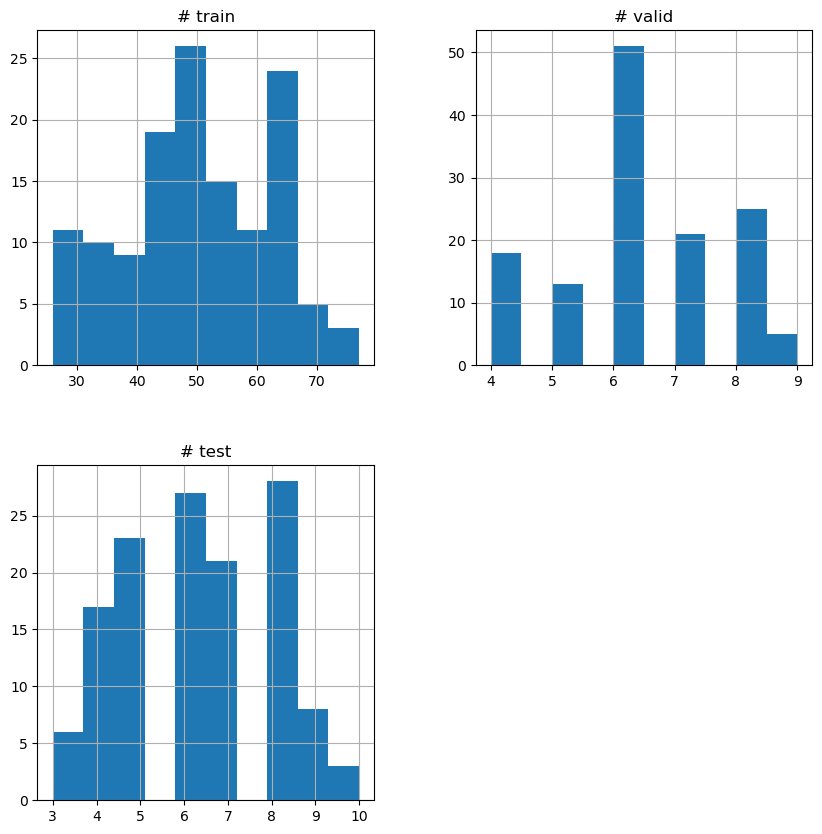

In [19]:
print("\n --- Split distribution ---")
display(df_stats.hist(figsize=(10, 10)))


 --- Class distribution ---


<Axes: xlabel='Dog Breed'>

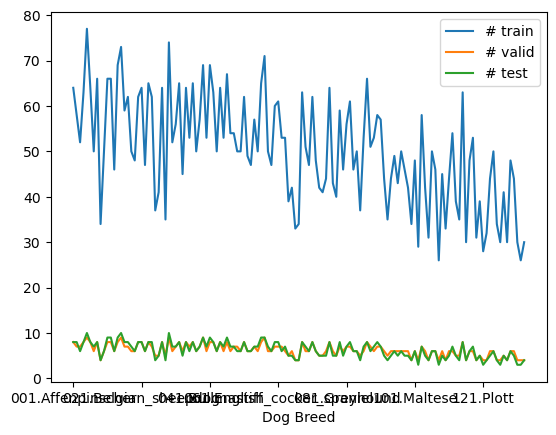

In [20]:
print("\n --- Class distribution ---")
df_stats.plot()

### OPTIONAL: Upload dataset to S3 (one time only)

In [21]:
# Set up SageMaker session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()  # Default S3 bucket

[01/22/25 12:16:08] INFO     Found credentials from IAM Role:                                   ]8;id=300;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=654172;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     Found credentials from IAM Role:                                   ]8;id=27363;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=315600;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

In [19]:
###Optional: Below sync method appears to be faster
#s3_prefix = 'dog-breed-classification'

In [20]:
#train_path = sagemaker_session.upload_data(path='./dogImages/train', bucket=bucket, key_prefix=f'{s3_prefix}/train')

In [21]:
#val_path = sagemaker_session.upload_data(path='./dogImages/valid', bucket=bucket, key_prefix=f'{s3_prefix}/val')

In [22]:
#test_path = sagemaker_session.upload_data(path='./dogImages/test', bucket=bucket, key_prefix=f'{s3_prefix}/test')

In [23]:
#print(f"Training data uploaded to: {train_path}")
#print(f"Validation data uploaded to: {val_path}")
#print(f"Test data uploaded to: {test_path}")

In [22]:
# S3 paths for data and model
#dataset_S3_TRAIN = f"s3://{bucket}/dogImages/train/"
dataset_S3 = f"s3://{bucket}/dogImages"
output_path = f"s3://{bucket}/dogImages/output/"

In [23]:
#!aws s3 sync ./dogImages/ {dataset_S3}

In [24]:
!aws s3 ls {dataset_S3}/

                           PRE output/
                           PRE test/
                           PRE train/
                           PRE valid/


## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [25]:
# Define the PyTorch estimator with metric definitions
estimator = PyTorch(
    entry_point="hpo.py",  # Updated script name
    role=role,
    framework_version="1.8",
    py_version="py3",
    instance_count=1,
    instance_type="ml.m5.xlarge",  # Use a smaller instance for faster testing
    hyperparameters={
        'batch-size': 64,
        'epochs': 3,
        'lr': 0.001
    },
    output_path=output_path,
    base_job_name="hpo-tuning-job",
    metric_definitions=[
        {'Name': 'epoch_accuracy', 'Regex': 'train:epoch_accuracy=([0-9\\.]+)'},
        {'Name': 'epoch_loss', 'Regex': 'train:epoch_loss=([0-9\\.]+)'}
    ]
)

[01/22/25 12:16:33] INFO     Found credentials from IAM Role:                                   ]8;id=669367;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=988251;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     Found credentials from IAM Role:                                   ]8;id=458262;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=611660;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

In [26]:
# Define hyperparameter ranges for tuning
hyperparameter_ranges = {
    'lr': ContinuousParameter(0.0001, 0.01),
    'batch-size': CategoricalParameter([32, 64, 128]),
    'epochs': IntegerParameter(1, 5)
}

In [27]:
hyperparameter_ranges

{'lr': <sagemaker.parameter.ContinuousParameter at 0x7f9bd8bc4cd0>,
 'batch-size': <sagemaker.parameter.CategoricalParameter at 0x7f9bd8bc53f0>,
 'epochs': <sagemaker.parameter.IntegerParameter at 0x7f9bd8bc5000>}

In [28]:
# Create the HyperparameterTuner object
tuner = HyperparameterTuner(
    estimator=estimator,
    objective_metric_name="epoch_accuracy",
    hyperparameter_ranges=hyperparameter_ranges,
    max_jobs=4,  # Reduce the number of jobs for faster testing
    max_parallel_jobs=2,  # Allow parallel jobs
    objective_type="Maximize",
    metric_definitions=[  # Add metric definitions here as well
        {'Name': 'epoch_accuracy', 'Regex': 'train:epoch_accuracy=([0-9\\.]+)'},
        {'Name': 'epoch_loss', 'Regex': 'train:epoch_loss=([0-9\\.]+)'}
    ]
)

In [31]:
# Start hyperparameter tuning
tuner.fit({
    "training": f"{dataset_S3}/train",
    "validation": f"{dataset_S3}/valid"
})

[01/21/25 09:44:37] INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=383094;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=326510;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#679\679]8;;\
                             instance_type, framework etc.                                                         

                    WARNING  No finished training job found associated with this estimator.       ]8;id=734359;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/estimator.py\estimator.py]8;;\:]8;id=972928;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/estimator.py#1914\1914]8;;\
                             Please make sure this estimator is only used for building workflow                    
                             config                                                                                

                    WARNING  No finished training job found associated with this estimator.       ]8;id=34230;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/estimator.py\estimator.py]8;;\:]8;id=528201;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/estimator.py#1914\1914]8;;\
                             Please make sure this estimator is only used for building workflow                    
                             config                                                                                

                    INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=297074;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=890164;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#679\679]8;;\
                             instance_type, framework etc.                                                         

                    INFO     Creating hyperparameter tuning job with name:                          ]8;id=510383;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=710453;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#3383\3383]8;;\
                             pytorch-training-250121-0944                                                          

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


### Check completed training jobs

In [29]:
# Initialize SageMaker client
sagemaker_client = boto3.client('sagemaker')

# Specify the tuning job name
tuning_job_name = 'pytorch-training-250121-0944'

# List training jobs for the tuning job
response = sagemaker_client.list_training_jobs_for_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name,
    MaxResults=50  # Adjust if needed
)

training_jobs = response['TrainingJobSummaries']

# Inspect each completed job
completed_jobs = [
    job['TrainingJobName']
    for job in training_jobs
    if job['TrainingJobStatus'] == 'Completed'
]

print(f"Completed training jobs: {completed_jobs}")


Completed training jobs: ['pytorch-training-250121-0944-004-243032d1', 'pytorch-training-250121-0944-003-27c257c1', 'pytorch-training-250121-0944-002-4dc8fbb9', 'pytorch-training-250121-0944-001-f1a32560']


In [30]:
for job_name in completed_jobs:
    print(f"Inspecting logs for training job: {job_name}")
    
    # Describe the training job to check status and details
    job_details = sagemaker_client.describe_training_job(TrainingJobName=job_name)
    print(f"Training Job Name: {job_name}")
    print(f"Hyperparameters: {job_details['HyperParameters']}")
    print(f"Output Location: {job_details['ModelArtifacts']['S3ModelArtifacts']}")


Inspecting logs for training job: pytorch-training-250121-0944-004-243032d1
Training Job Name: pytorch-training-250121-0944-004-243032d1
Hyperparameters: {'_tuning_objective_metric': 'epoch_accuracy', 'batch-size': '"32"', 'epochs': '4', 'lr': '0.0004032455649152089', 'sagemaker_container_log_level': '20', 'sagemaker_estimator_class_name': '"PyTorch"', 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"', 'sagemaker_job_name': '"hpo-tuning-job-2025-01-21-09-44-37-102"', 'sagemaker_program': '"hpo.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-861747698849/hpo-tuning-job-2025-01-21-09-44-37-102/source/sourcedir.tar.gz"'}
Output Location: s3://sagemaker-us-east-1-861747698849/dogImages/output/pytorch-training-250121-0944-004-243032d1/output/model.tar.gz
Inspecting logs for training job: pytorch-training-250121-0944-003-27c257c1
Training Job Name: pytorch-training-250121-0944-003-27c257c1
Hyperparameters: {'_tuning_objective_metr

### Retrieve the best training job

In [ ]:
# Save name of best training job
best_training_job = tuner.best_training_job()

print(f"Best training job: {best_training_job}")

### Retrive the best training job from existing, completed training

In [32]:
import boto3

# Initialize SageMaker client
sagemaker_client = boto3.client('sagemaker')

# Specify the hyperparameter tuning job name
tuning_job_name = "pytorch-training-250121-0944"

# Describe the tuning job to get its details
response = sagemaker_client.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name
)

# Extract the best training job name
best_training_job = response['BestTrainingJob']['TrainingJobName']
print(f"Best Training Job: {best_training_job}")

# Describe the best training job to retrieve model artifact details
best_job_response = sagemaker_client.describe_training_job(
    TrainingJobName=best_training_job
)
model_artifacts = best_job_response['ModelArtifacts']['S3ModelArtifacts']
print(f"Model Artifacts S3 Path: {model_artifacts}")


Best Training Job: pytorch-training-250121-0944-004-243032d1
Model Artifacts S3 Path: s3://sagemaker-us-east-1-861747698849/dogImages/output/pytorch-training-250121-0944-004-243032d1/output/model.tar.gz


### Retrieve the best estimator

In [33]:
# Optional: If you are working outside the hyperparameter tuner context,
# attaching estimator to PyTorch, provides more control and flexibility 
# best_estimator = PyTorch.attach(best_training_job)
# print(f"Best estimator: {best_estimator}")

In [34]:
# Save name of best estimator
#best_estimator = tuner.best_estimator()
#print(f"Best estimator: {best_estimator}")

In [35]:
# Get the hyperparameters
#best_estimator.hyperparameters()

### Retrieve the best estimator from existing, completed training

In [36]:
import boto3
from sagemaker.pytorch import PyTorch

# Initialize SageMaker client
sagemaker_client = boto3.client('sagemaker')

# Specify the tuning job name
tuning_job_name = "pytorch-training-250121-0944"

# Describe the tuning job to fetch its details
tuning_job_details = sagemaker_client.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name
)

# Extract the best training job name and hyperparameters
best_training_job_name = tuning_job_details['BestTrainingJob']['TrainingJobName']
print(f"Best Training Job Name: {best_training_job_name}")

# Describe the best training job to get its hyperparameters and model artifacts
best_training_job_details = sagemaker_client.describe_training_job(
    TrainingJobName=best_training_job_name
)

# Extract the best hyperparameters
best_hyperparameters = best_training_job_details['HyperParameters']
print("Best Hyperparameters:")
print(best_hyperparameters)

# Extract model artifact path
model_artifacts = best_training_job_details['ModelArtifacts']['S3ModelArtifacts']
print(f"Model Artifacts S3 Path: {model_artifacts}")

Best Training Job Name: pytorch-training-250121-0944-004-243032d1
Best Hyperparameters:
{'_tuning_objective_metric': 'epoch_accuracy', 'batch-size': '"32"', 'epochs': '4', 'lr': '0.0004032455649152089', 'sagemaker_container_log_level': '20', 'sagemaker_estimator_class_name': '"PyTorch"', 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"', 'sagemaker_job_name': '"hpo-tuning-job-2025-01-21-09-44-37-102"', 'sagemaker_program': '"hpo.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-861747698849/hpo-tuning-job-2025-01-21-09-44-37-102/source/sourcedir.tar.gz"'}
Model Artifacts S3 Path: s3://sagemaker-us-east-1-861747698849/dogImages/output/pytorch-training-250121-0944-004-243032d1/output/model.tar.gz


## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [37]:
# TODO: Set up debugging and profiling rules and hooks
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

collection_configs=[
    CollectionConfig(
        name="CrossEntopyLoss_output_0",
        parameters={
            "include_regex": "CrossEntropyLoss_output_0",
            "train.save_interval": "1",
            "eval.save_interval": "1"
        }
    )
]

hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "5",
        "eval.save_interval": "1"
    },
    collection_configs=collection_configs
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500,
    framework_profile_params=FrameworkProfile(num_steps=10)
)

[01/22/25 12:17:43] WARNING  Framework profiling will be deprecated from tensorflow 2.12 and     ]8;id=746848;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py\deprecations.py]8;;\:]8;id=958424;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py#34\34]8;;\
                             pytorch 2.0 in sagemaker>=2.                                                          
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

In [38]:
# Creating the hyperparameters dictionary
select_batch_size = eval(best_hyperparameters.get('batch-size', None))
selected_lr = best_hyperparameters.get('lr', None)

hyperparameters = {
    'batch-size': select_batch_size,
    'lr': selected_lr
}

In [40]:
# TODO: Create and fit an estimator
estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name="final-training", #model-training
    role=role,
    py_version='py3',
    framework_version="1.8",
    hyperparameters=hyperparameters,
    instance_count=1,
    instance_type="ml.g4dn.xlarge", # ml.m5.large
    rules=rules,
    debugger_hook_config=hook_config
)

In [41]:
inputs_mapping = {
    "training": f"{dataset_S3}/train",
    "validation": f"{dataset_S3}/valid",
    "testing": f"{dataset_S3}/test"
}

In [42]:
estimator.fit(wait=True, inputs=inputs_mapping)

[01/22/25 12:19:07] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=888665;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=967657;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#90\90]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

[01/22/25 12:19:08] INFO     Ignoring unnecessary instance type: None.                            ]8;id=577031;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=997490;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#528\528]8;;\

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=908548;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=477776;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#528\528]8;;\

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=432293;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=943685;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#528\528]8;;\

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=250486;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=361948;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#528\528]8;;\

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=228366;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=809889;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#528\528]8;;\

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=129950;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=758347;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#528\528]8;;\

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=381302;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=271862;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#528\528]8;;\

                    INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=722073;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=293687;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#679\679]8;;\
                             instance_type, framework etc.                                                         

                    INFO     Creating training-job with name:                                       ]8;id=613174;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=615542;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\
                             final-training-2025-01-22-12-19-07-850                                                

2025-01-22 12:19:10 Starting - Starting the training job...
2025-01-22 12:19:41 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LossNotDecreasing: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
..
.....01-22 12:20:04 Downloading - Downloading input data.
....................Downloading - Downloading the training image.
bash: cannot set terminal process group (-1): Inappropriate ioctl for devices..
bash: no job control in this shell
2025-01-22 12:24:45,379 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2025-01-22 12:24:45,410 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2025-01-22 12:24:45,414 sagemaker_pytorch_container.training INFO     Invoking user training script.
2025-01-22 12:24:45,781 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "a

In [43]:
estimator

In [44]:
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

print(f"Training jobname: {job_name}")
print(f"Client: {client}")
print(f"Description: {description}")

Training jobname: final-training-2025-01-22-12-19-07-850
Client: <botocore.client.SageMaker object at 0x7f9bd2b132b0>
Description: {'TrainingJobName': 'final-training-2025-01-22-12-19-07-850', 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:861747698849:training-job/final-training-2025-01-22-12-19-07-850', 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-861747698849/final-training-2025-01-22-12-19-07-850/output/model.tar.gz'}, 'TrainingJobStatus': 'Completed', 'SecondaryStatus': 'Completed', 'HyperParameters': {'batch-size': '"32"', 'lr': '"0.0004032455649152089"', 'sagemaker_container_log_level': '20', 'sagemaker_job_name': '"final-training-2025-01-22-12-19-07-850"', 'sagemaker_program': '"train_model.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-861747698849/final-training-2025-01-22-12-19-07-850/source/sourcedir.tar.gz"'}, 'AlgorithmSpecification': {'TrainingImage': '763104351884.dkr.ecr.us-east-1.amazonaws.com/pyto

### Retrieve information from existing, completed training

In [46]:
# Define the existing training job name
job_name = "final-training-2025-01-22-12-19-07-850"

# Access the SageMaker client from the estimator's session
client = estimator.sagemaker_session.sagemaker_client

# Fetch the details of the specified training job
description = client.describe_training_job(TrainingJobName=job_name)

# Print the required information
print(f"Training job name: {job_name}")
print(f"Client: {client}")
print("Training Job Description:")
print(description)


Training job name: final-training-2025-01-22-12-19-07-850
Client: <botocore.client.SageMaker object at 0x7f9bd2b132b0>
Training Job Description:
{'TrainingJobName': 'final-training-2025-01-22-12-19-07-850', 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:861747698849:training-job/final-training-2025-01-22-12-19-07-850', 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-861747698849/final-training-2025-01-22-12-19-07-850/output/model.tar.gz'}, 'TrainingJobStatus': 'Completed', 'SecondaryStatus': 'Completed', 'HyperParameters': {'batch-size': '"32"', 'lr': '"0.0004032455649152089"', 'sagemaker_container_log_level': '20', 'sagemaker_job_name': '"final-training-2025-01-22-12-19-07-850"', 'sagemaker_program': '"train_model.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-861747698849/final-training-2025-01-22-12-19-07-850/source/sourcedir.tar.gz"'}, 'AlgorithmSpecification': {'TrainingImage': '763104351884.dkr.ecr.us-east-1.amaz

### Plot a debugging output

In [ ]:
#from smdebug.trials import create_trial
#from smdebug.core.modes import ModeKeys

#trial = create_trial(estimator.latest_job_debugger_artifacts_path())

### Plot a debugging output from existing, completed training

In [48]:
import boto3

# Initialize SageMaker client
client = boto3.client('sagemaker')

# Specify the training job name
completed_job_name = "final-training-2025-01-22-12-19-07-850"

# Get training job details
job_description = client.describe_training_job(TrainingJobName=completed_job_name)

# Extract Debugger artifacts path
debugger_artifacts_path = job_description.get('DebugHookConfig', {}).get('S3OutputPath', None)
print(f"Debugger artifacts path: {debugger_artifacts_path}")



Debugger artifacts path: s3://sagemaker-us-east-1-861747698849/


In [ ]:
# Check if expected files, tfevents, json etc, exist in directory
#!aws s3 ls s3://sagemaker-us-east-1-861747698849/final-training-2025-01-22-12-19-07-850/debug-output/ --recursive

In [69]:
from smdebug.trials import create_trial

# Path to Debugger artifacts
debugger_artifacts_path = "s3://sagemaker-us-east-1-861747698849/final-training-2025-01-22-12-19-07-850/debug-output/"

try:
    # Create a trial from the Debugger artifacts
    trial = create_trial(debugger_artifacts_path)
    print("Trial successfully created.")

    # List all available tensors
    print("Available Tensors:")
    for tensor in trial.tensor_names():
        print(tensor)

except Exception as e:
    print(f"Error creating trial: {e}")


[01/22/25 14:36:59] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=681658;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=208068;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

Trial successfully created.
Available Tensors:
CrossEntropyLoss_output_0
gradient/ResNet_fc.0.bias
gradient/ResNet_fc.0.weight
gradient/ResNet_fc.2.bias
gradient/ResNet_fc.2.weight
layer1.0.relu_input_0
layer1.0.relu_input_1
layer1.0.relu_input_2
layer1.1.relu_input_0
layer1.1.relu_input_1
layer1.1.relu_input_2
layer1.2.relu_input_0
layer1.2.relu_input_1
layer1.2.relu_input_2
layer2.0.relu_input_0
layer2.0.relu_input_1
layer2.0.relu_input_2
layer2.1.relu_input_0
layer2.1.relu_input_1
layer2.1.relu_input_2
layer2.2.relu_input_0
layer2.2.relu_input_1
layer2.2.relu_input_2
layer2.3.relu_input_0
layer2.3.relu_input_1
layer2.3.relu_input_2
layer3.0.relu_input_0
layer3.0.relu_input_1
layer3.0.relu_input_2
layer3.1.relu_input_0
layer3.1.relu_input_1
layer3.1.relu_input_2
layer3.2.relu_input_0
layer3.2.relu_input_1
layer3.2.relu_input_2
layer3.3.relu_input_0
layer3.3.relu_input_1
layer3.3.relu_input_2
layer3.4.relu_input_0
layer3.4.relu_input_1
layer3.4.relu_input_2
layer3.5.relu_input_0
layer

In [70]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))

1463

In [71]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL))

216

In [73]:
import logging
logging.getLogger().setLevel(logging.CRITICAL)

### Functions to plot the output sensors

Loaded TRAIN data
Loaded EVAL data
Completed TRAIN plot
Completed EVAL plot


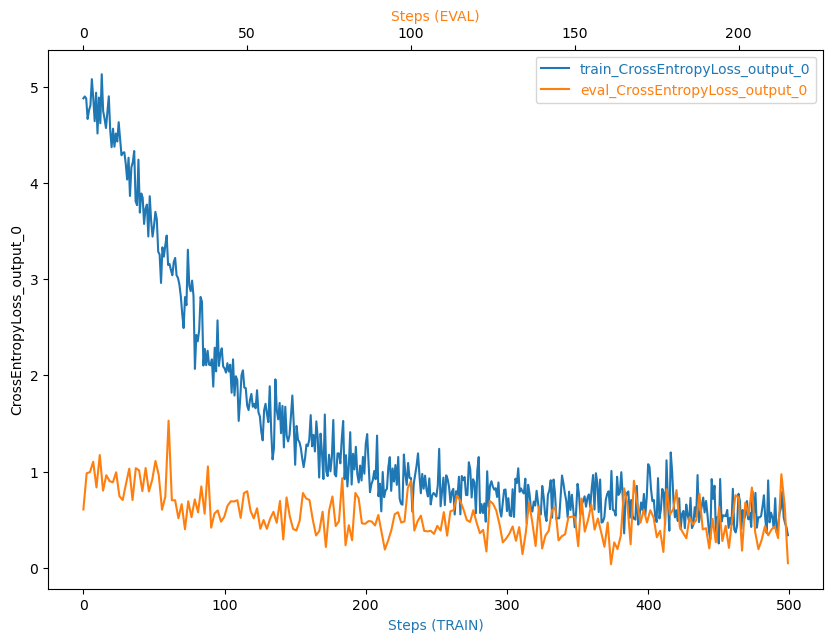

In [75]:
from mpl_toolkits.axes_grid1 import host_subplot
from smdebug.core.modes import ModeKeys
import matplotlib.pyplot as plt

def get_data_optimized(trial, tname, mode, limit=None):
    """
    Fetch data for a tensor efficiently, with an optional limit on the number of steps.
    """
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    
    if limit:
        steps = steps[:limit]  # Limit the number of steps
    
    # Fetch values for all steps in bulk
    vals = [tensor.value(step, mode=mode) for step in steps]  # Ensure we process steps iteratively
    return steps, vals

def plot_tensor_optimized(trial, tensor_name, train_limit=None, eval_limit=None):
    """
    Plot tensor data for both training and evaluation, with optimizations for speed.
    """
    # Fetch training data
    steps_train, vals_train = get_data_optimized(trial, tensor_name, mode=ModeKeys.TRAIN, limit=train_limit)
    print("Loaded TRAIN data")

    # Fetch evaluation data
    steps_eval, vals_eval = get_data_optimized(trial, tensor_name, mode=ModeKeys.EVAL, limit=eval_limit)
    print("Loaded EVAL data")

    # Plotting
    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=f"train_{tensor_name}")
    print("Completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label=f"eval_{tensor_name}")
    print("Completed EVAL plot")

    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)
    plt.show()

# Call the optimized plot function
plot_tensor_optimized(trial, "CrossEntropyLoss_output_0", train_limit=500, eval_limit=500)



#### Checking system utilization

In [76]:
# Check folder content
#!aws s3 ls s3://sagemaker-us-east-1-861747698849/final-training-2025-01-22-12-19-07-850/profiler-output/system/ --recursive

In [77]:
import boto3
import os

# Define S3 path and local download location
profiler_s3_path = "s3://sagemaker-us-east-1-861747698849/final-training-2025-01-22-12-19-07-850/profiler-output/system/"
local_profiler_path = "./profiler_data"
os.makedirs(local_profiler_path, exist_ok=True)

# Download files
s3 = boto3.client("s3")
bucket_name, prefix = profiler_s3_path.replace("s3://", "").split("/", 1)
paginator = s3.get_paginator("list_objects_v2")
for page in paginator.paginate(Bucket=bucket_name, Prefix=prefix):
    for obj in page.get("Contents", []):
        local_file_path = os.path.join(local_profiler_path, obj["Key"].split("/")[-1])
        s3.download_file(bucket_name, obj["Key"], local_file_path)
print(f"Profiler data downloaded to {local_profiler_path}")


Profiler data downloaded to ./profiler_data


In [78]:
import os

# List all files in the profiler directory
local_profiler_path = "./profiler_data"
profiler_files = os.listdir(local_profiler_path)
print("Available Profiler Files:", profiler_files)


Available Profiler Files: ['1737463740.algo-1.json', '1737549000.algo-1.json', '1737550500.algo-1.json', '1737460500.algo-1.json', '1737464220.algo-1.json', '1737549300.algo-1.json', '1737462600.algo-1.json', '1737553440.algo-1.json', '1737464100.algo-1.json', '1737458280.algo-1.json', '1737551100.algo-1.json', '1737552360.algo-1.json', '1737549480.algo-1.json', '1737554520.algo-1.json', '1737459420.algo-1.json', '1737462120.algo-1.json', '1737459840.algo-1.json', '1737459360.algo-1.json', '1737551400.algo-1.json', '1737458220.algo-1.json', '1737552840.algo-1.json', '1737549420.algo-1.json', '1737552480.algo-1.json', '1737458400.algo-1.json', '1737458340.algo-1.json', '1737552900.algo-1.json', '1737462060.algo-1.json', '1737553140.algo-1.json', '1737462660.algo-1.json', '1737457800.algo-1.json', '1737553380.algo-1.json', '1737551340.algo-1.json', '1737459060.algo-1.json', '1737460440.algo-1.json', '1737553560.algo-1.json', '1737554760.algo-1.json', '1737548520.algo-1.json', '1737550860

In [79]:
!head ./profiler_data/1737457740.algo-1.json

{"Type":"memory","Name":"MemoryUsedPercent","Dimension":"","Value":6.33,"NodeId":"algo-1","Timestamp":1737457753.501015}
{"Type":"memory","Name":"MemoryUsedPercent","Dimension":"","Value":6.67,"NodeId":"algo-1","Timestamp":1737457754.001743}
{"Type":"cpu","Name":"cpu0","Dimension":"CPUUtilization","Value":100.00,"NodeId":"algo-1","Timestamp":1737457754.001811}
{"Type":"cpu","Name":"cpu0","Dimension":"I/OWaitPercentage","Value":4.00,"NodeId":"algo-1","Timestamp":1737457754.001811}
{"Type":"cpu","Name":"cpu1","Dimension":"CPUUtilization","Value":100.00,"NodeId":"algo-1","Timestamp":1737457754.001811}
{"Type":"cpu","Name":"cpu1","Dimension":"I/OWaitPercentage","Value":0.00,"NodeId":"algo-1","Timestamp":1737457754.001811}
{"Type":"i/o","Name":"IOPS","Dimension":"","Value":127.76,"NodeId":"algo-1","Timestamp":1737457754.001866}
{"Type":"i/o","Name":"ReadThroughputInBytesPerSecond","Dimension":"","Value":0.00,"NodeId":"algo-1","Timestamp":1737457754.001866}
{"Type":"i/o","Name":"WriteThrough

In [80]:
import json

# File path
profiler_file = "./profiler_data/1737457740.algo-1.json"

# Initialize storage for parsed data
cpu_utilization = []
timestamps = []

# Parse and filter metrics
with open(profiler_file, "r") as f:
    for line in f:
        data = json.loads(line.strip())
        # Filter for CPU utilization
        if data["Type"] == "cpu" and data["Dimension"] == "CPUUtilization":
            cpu_utilization.append(data["Value"])
            timestamps.append(data["Timestamp"])

# Output summary
print(f"Loaded {len(cpu_utilization)} CPU utilization entries.")


Loaded 184 CPU utilization entries.


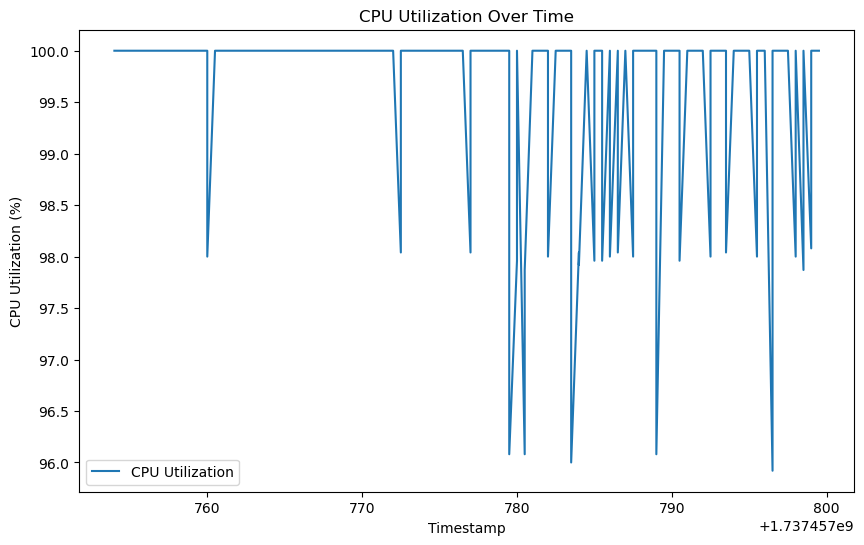

In [81]:
import matplotlib.pyplot as plt

# Plot CPU utilization over time
plt.figure(figsize=(10, 6))
plt.plot(timestamps, cpu_utilization, label="CPU Utilization")
plt.xlabel("Timestamp")
plt.ylabel("CPU Utilization (%)")
plt.title("CPU Utilization Over Time")
plt.legend()
plt.show()



### SageMaker Debugger Profiling Report
Save the profiler report a S3 bucket. Fetch and display the path of the report below.

In [82]:
!aws s3 ls s3://sagemaker-us-east-1-861747698849/final-training-2025-01-22-12-19-07-850/rule-output/ProfilerReport/ --recursive

2025-01-22 14:09:48     380304 final-training-2025-01-22-12-19-07-850/rule-output/ProfilerReport/profiler-output/profiler-report.html
2025-01-22 14:09:47     230735 final-training-2025-01-22-12-19-07-850/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2025-01-22 14:09:42        561 final-training-2025-01-22-12-19-07-850/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2025-01-22 14:09:42     526480 final-training-2025-01-22-12-19-07-850/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2025-01-22 14:09:42        126 final-training-2025-01-22-12-19-07-850/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2025-01-22 14:09:42        131 final-training-2025-01-22-12-19-07-850/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2025-01-22 14:09:42       1371 final-training-2025-01-22-12-19-07-850/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottle

In [83]:
import boto3

# Define the S3 bucket and prefix
bucket_name = "sagemaker-us-east-1-861747698849"
report_prefix = "final-training-2025-01-22-12-19-07-850/rule-output/ProfilerReport/"

# List files in the profiler report directory
s3 = boto3.client("s3")
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=report_prefix)

# Extract the path to the HTML report
report_path = None
if "Contents" in response:
    for obj in response["Contents"]:
        if obj["Key"].endswith(".html"):  # Look for the HTML file
            report_path = f"s3://{bucket_name}/{obj['Key']}"
            print(f"Profiler Report Path: {report_path}")
            break

if not report_path:
    print("Profiler Report HTML file not found.")


Profiler Report Path: s3://sagemaker-us-east-1-861747698849/final-training-2025-01-22-12-19-07-850/rule-output/ProfilerReport/profiler-output/profiler-report.html


**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [84]:
from IPython.display import IFrame

# Local path to the downloaded Profiler Report HTML file
local_report_path = "./profiler-report.html"

# Display the report using IFrame
IFrame(src=local_report_path, width="100%", height="800px")


## Model Deploying

In [85]:
from sagemaker.pytorch import PyTorchModel

In [86]:
import boto3
from sagemaker import get_execution_role
from sagemaker.model import Model

# Specify S3 model artifact path
model_s3_path = "s3://sagemaker-us-east-1-861747698849/final-training-2025-01-22-12-19-07-850/output/model.tar.gz"

# Define deployment parameters
role = get_execution_role()
endpoint_name = "dog-breed-classification-model-endpoint"
instance_type = "ml.m5.large"  # ml.m5.large, ml.t2.medium ... choose an instance type suitable for your workload ... ml.p3.2xlarge for cuda


In [87]:
#from sagemaker.pytorch.model import PyTorchModel

# Create a SageMaker model object
pytorch_model = PyTorchModel(
    model_data=model_s3_path,
    role=role,
    framework_version="1.8",
    py_version="py3",
    entry_point="inference.py",
)

print("SageMaker model object created.")


SageMaker model object created.


In [93]:
# Deploy the model to an endpoint
predictor = pytorch_model.deploy(
    initial_instance_count=1,
    instance_type=instance_type,
    endpoint_name=endpoint_name,
)

print(f"Endpoint '{endpoint_name}' deployed successfully.")


------!Endpoint 'dog-breed-classification-model-endpoint' deployed successfully.


### Check existing endpoints

In [94]:
!aws sagemaker list-endpoints --query "Endpoints[].EndpointName"


[
    "dog-breed-classification-model-endpoint"
]


### Delete older endpoint configurations if necessary

In [95]:
!aws sagemaker list-endpoint-configs --query "EndpointConfigs[].EndpointConfigName"


[
    "dog-breed-classification-model-endpoint"
]


In [91]:
#!aws sagemaker delete-endpoint-config --endpoint-config-name <endpoint name>

#### Load and preprocess image to send to endpoint for prediction

Breed:  046.Cavalier_king_charles_spaniel
Image Path:  ./dogImages/test/046.Cavalier_king_charles_spaniel/Cavalier_king_charles_spaniel_03254.jpg


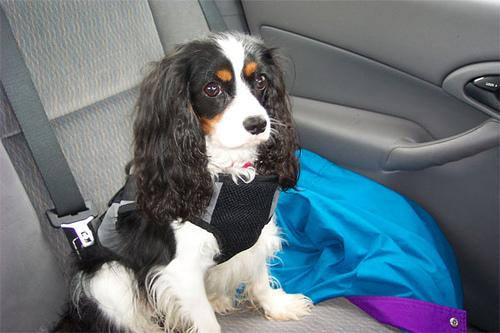

In [108]:
import os
import random
import json
import boto3
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# Dataset path
dataset_S3_test = './dogImages/test'

# Select a random image
file_handles = os.listdir(dataset_S3_test)
random_breed = random.choice(file_handles)  # Pick a random breed folder
file_handles_breed = os.listdir(f"{dataset_S3_test}/{random_breed}")
random_img = random.choice(file_handles_breed)  # Pick a random image

print("Breed: ", random_breed)
img_path = f"{dataset_S3_test}/{random_breed}/{random_img}"
print("Image Path: ", img_path)

# Load the image
img = Image.open(img_path)
img

#### Prediction

In [110]:
def process_image(img):    
    image = img.convert('RGB')
    data_transform = transforms.Compose(
        [transforms.Resize(128),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
    )

    return data_transform(image)[:3,:,:].unsqueeze(0).numpy()

img_processed = process_image(img)

In [ ]:
response = predictor.predict(img_processed)
print("Prediction result with processing:")
print(np.argmax(response[0]) + 1)
print("Breed: ", random_breed)

expected 046

In [112]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

### Optional: Asynchronous Endpoint¶

In [163]:
from sagemaker.async_inference import AsyncInferenceConfig
from sagemaker.pytorch import PyTorchModel


In [164]:
# Specify output location for async results
async_config = AsyncInferenceConfig(
    output_path="s3://sagemaker-us-east-1-861747698849/async-output/",
    max_concurrent_invocations_per_instance=1  
)


In [165]:
# Create the PyTorch model object
model = PyTorchModel(
    model_data="s3://sagemaker-us-east-1-861747698849/final-training-2025-01-22-12-19-07-850/output/model.tar.gz",  # Model artifacts
    role=role,  # IAM role with permissions
    framework_version="1.9.0",  # PyTorch version
    py_version="py38",
    entry_point="inference.py"  # Your custom inference script
)

# Deploy the asynchronous endpoint
predictor = model.deploy(
    instance_type="ml.m5.large",  # Instance type
    initial_instance_count=1,     # Number of instances
    endpoint_name="dog-breed-classification-async-endpoint",  # Endpoint name
    async_inference_config=async_config  # Async inference configuration
)

print("Asynchronous endpoint deployed successfully.")


[01/21/25 19:01:45] INFO     Repacking model artifact                                                  ]8;id=44375;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/model.py\model.py]8;;\:]8;id=409740;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/model.py#819\819]8;;\
                             (s3://sagemaker-us-east-1-861747698849/model-training-2025-01-21-11-08-20             
                             -514/output/model.tar.gz), script artifact (None), and dependencies ([])              
                             into single tar.gz file located at                                                    
                             s3://sagemaker-us-east-1-861747698849/pytorch-inference-2025-01-21-19-01-             
                             44-704/model.tar.gz. This may take some time depending on model size...               

[01/21/25 19:01:56] INFO     Creating model with name: pytorch-inference-2025-01-21-19-01-56-041    ]8;id=370364;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=351308;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\

                    INFO     Creating endpoint-config with name                                     ]8;id=874819;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=810611;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#5889\5889]8;;\
                             dog-breed-classification-async-endpoint                                               

                    INFO     Creating endpoint with name dog-breed-classification-async-endpoint    ]8;id=120845;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=865052;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4711\4711]8;;\

-------!Asynchronous endpoint deployed successfully.


### Select random image and save a json file

In [186]:
import os
import random
from PIL import Image
import numpy as np
import json
import boto3

# Dataset path
dataset_S3_test = './dogImages/test'

# Select a random image
file_handles = os.listdir(dataset_S3_test)
random_breed = random.choice(file_handles)  # Pick a random breed folder
file_handles_breed = os.listdir(f"{dataset_S3_test}/{random_breed}")
random_img = random.choice(file_handles_breed)  # Pick a random image

print("Breed: ", random_breed)
img_path = f"{dataset_S3_test}/{random_breed}/{random_img}"
print("Image Path: ", img_path)

# Load the image
img = Image.open(img_path)

# Preprocess the image
img_resized = img.resize((224, 224))  # Resize to model input size
img_array = np.asarray(img_resized).astype(np.float32) / 255.0  # Normalize
img_transposed = np.transpose(img_array, (2, 0, 1))  # Rearrange to (C, H, W)
img_batch = np.expand_dims(img_transposed, axis=0)  # Add batch dimension

print("Input shape for model:", img_batch.shape)

# Save the preprocessed image as JSON
input_json = {"inputs": img_batch.tolist()}
with open("input.json", "w") as f:
    json.dump(input_json, f)

print("Image input saved to input.json.")


Breed:  111.Norwich_terrier
Image Path:  ./dogImages/test/111.Norwich_terrier/Norwich_terrier_07277.jpg
Input shape for model: (1, 3, 224, 224)
Image input saved to input.json.


In [187]:
img_batch

array([[[[0.11764706, 0.1254902 , 0.12941177, ..., 0.2627451 ,
          0.25882354, 0.25882354],
         [0.10588235, 0.10980392, 0.11372549, ..., 0.17254902,
          0.1764706 , 0.1764706 ],
         [0.10196079, 0.10588235, 0.10980392, ..., 0.10980392,
          0.11372549, 0.11372549],
         ...,
         [0.23921569, 0.2784314 , 0.29803923, ..., 0.3254902 ,
          0.32941177, 0.3372549 ],
         [0.26666668, 0.28235295, 0.25490198, ..., 0.36862746,
          0.34509805, 0.34117648],
         [0.2627451 , 0.31764707, 0.2627451 , ..., 0.32156864,
          0.30588236, 0.34509805]],

        [[0.11764706, 0.1254902 , 0.12941177, ..., 0.25882354,
          0.2627451 , 0.27058825],
         [0.10588235, 0.10980392, 0.11372549, ..., 0.16078432,
          0.1764706 , 0.1764706 ],
         [0.10196079, 0.10588235, 0.10980392, ..., 0.10196079,
          0.10588235, 0.10980392],
         ...,
         [0.29803923, 0.34509805, 0.37254903, ..., 0.40784314,
          0.4       , 0.3

In [188]:
# Define S3 input path
input_s3_path = "s3://sagemaker-us-east-1-861747698849/async-input/input.json"

# Upload the file
s3_client = boto3.client("s3")
s3_client.upload_file("input.json", "sagemaker-us-east-1-861747698849", "async-input/input.json")

print(f"Input uploaded to: {input_s3_path}")


Input uploaded to: s3://sagemaker-us-east-1-861747698849/async-input/input.json


In [189]:
# Invoke the asynchronous endpoint
runtime_client = boto3.client("sagemaker-runtime")
response = runtime_client.invoke_endpoint_async(
    EndpointName="dog-breed-classification-async-endpoint",
    InputLocation=input_s3_path,  # S3 input file path
    ContentType="application/json"
)

# Get the inference response
print("Asynchronous inference request submitted.")
print(f"Response: {response}")


Asynchronous inference request submitted.
Response: {'ResponseMetadata': {'RequestId': 'afc9973f-98c4-4ebd-92c1-ff8cc33437fc', 'HTTPStatusCode': 202, 'HTTPHeaders': {'x-amzn-requestid': 'afc9973f-98c4-4ebd-92c1-ff8cc33437fc', 'x-amzn-sagemaker-outputlocation': 's3://sagemaker-us-east-1-861747698849/async-output/1a095cd3-3c56-4585-9d0d-d9971d6358ce.out', 'x-amzn-sagemaker-failurelocation': 's3://sagemaker-us-east-1-861747698849/async-endpoint-failures/pytorch-inference-2025-01-21-19-01-56-041-1737486116-e330/1a095cd3-3c56-4585-9d0d-d9971d6358ce-error.out', 'date': 'Tue, 21 Jan 2025 19:50:12 GMT', 'content-type': 'application/json', 'content-length': '54', 'connection': 'keep-alive'}, 'RetryAttempts': 0}, 'OutputLocation': 's3://sagemaker-us-east-1-861747698849/async-output/1a095cd3-3c56-4585-9d0d-d9971d6358ce.out', 'FailureLocation': 's3://sagemaker-us-east-1-861747698849/async-endpoint-failures/pytorch-inference-2025-01-21-19-01-56-041-1737486116-e330/1a095cd3-3c56-4585-9d0d-d9971d6358

In [ ]:
#!aws s3 ls s3://sagemaker-us-east-1-861747698849/async-output/ --recursive


In [ ]:
#!aws s3 ls s3://sagemaker-us-east-1-861747698849/async-endpoint-failures/ --recursive

In [201]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

[01/21/25 22:22:17] INFO     Deleting endpoint configuration with name:                             ]8;id=323263;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=780535;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4865\4865]8;;\
                             dog-breed-classification-async-endpoint                                               

                    INFO     Deleting endpoint with name: dog-breed-classification-async-endpoint   ]8;id=234001;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=667612;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4855\4855]8;;\